# Course Review Sentiment Analysis with Naive Bayes Classifier

This notebook aims to perform sentiment analysis on course reviews using a Naive Bayes classifier. The dataset consists of reviews for various online courses, along with their ratings. The goal is to predict whether a review is positive or negative based on its textual content.

## Steps Taken:

1. **Data Loading and Exploration:**
   - Load the dataset containing course reviews.
   - Explore the data to understand its structure and contents.

2. **Data Preprocessing:**
   - Clean and normalize the text data by removing punctuation, special characters, and digits.
   - Handle missing values and perform basic data transformations.

3. **Exploratory Data Analysis (EDA):**
   - Analyze the distribution of review ratings.
   - Explore the relationship between review ratings and review lengths.

4. **Text Processing:**
   - Tokenize the text data and convert it into numerical features using TF-IDF vectorization.
   - Split the dataset into training and testing sets.

5. **Model Building:**
   - Implement a Multinomial Naive Bayes classifier.
   - Train the classifier on the training data.

6. **Model Evaluation:**
   - Test the performance of the trained model on the testing data.
   - Evaluate the model using classification metrics such as precision, recall, and F1-score.
   - Visualize the performance using a confusion matrix.

7. **Handling Class Imbalance:**
   - Address the imbalance in the dataset by upsampling the minority class.
   - Retrain the model on the upsampled data and evaluate its performance.

8. **Binary Classification:**
   - Convert the multi-class classification problem into a binary classification problem (good vs. bad reviews).
   - Train and evaluate the binary classifier using the same steps as before.

9. **Handling Class Imbalance (Binary Classification):**
   - Upsample the minority class in the binary classification dataset.
   - Retrain the binary classifier on the upsampled data and evaluate its performance.


Relevant Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import string
import re
import pandas as pd
from matplotlib import pyplot as plt
from typing import Sequence, Optional
import numpy as np
import seaborn as sns
sns.set_theme('notebook')

Functions for cleaning text and plotting histogram

In [2]:
# Function for cleaning and normalizing text:

def clean_text(text: str) -> str:
    """
    Clean and normalize the input text by performing the following steps:
    1. Convert the text to lowercase.
    2. Remove punctuation marks from the text.
    3. Remove special characters, punctuation, and digits from the text.
    4. Replace multiple consecutive whitespaces with a single whitespace.

    Parameters:
    - text (str): The input text to be cleaned.

    Returns:
    - str: The cleaned and normalized text.

    Example:
    >>> clean_text("Hello! This is a sample text. It contains special characters & digits 123.")
    'hello this is a sample text it contains special characters digits'
    """
    text = text.lower()
    text = text.translate(str.maketrans('','',string.punctuation)) # Removes any punctuations present in the text
    text = re.sub(r'^[a-zA-Z]\s', '', text) # Removes special characters, punctuations and digits
    text = re.sub(r'\s+', '', text) # Removes extra whitespaces
    return text

# A function to plot histogram with defined parameters pre calculated
def plot_histogram(data: Sequence, x_label: str, y_label: str, title: str, n_bins: Optional[int] = None) -> None:
    """
    Plot a histogram of the input data with specified parameters.

    Parameters:
    - data (Sequence): The input data for which the histogram will be plotted.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - title (str): The title of the histogram plot.
    - n_bins (Optional[int]): The number of bins for the histogram. If not provided, 
      it is calculated based on the Freedman-Diaconis rule.

    Returns:
    - None

    Example:
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> data = np.random.normal(loc=0, scale=1, size=1000)
    >>> plot_histogram(data, x_label="Value", y_label="Frequency", title="Histogram of Data")
    """
    if n_bins is None:
        n = len(data)
        q3, q1 = np.percentile(data, [75, 25])
        iqr = q3 - q1
        bin_width = 2 * iqr * (n**(-1/3))
        if np.isinf(bin_width) or np.isnan(bin_width) or bin_width == 0:
            n_bins = np.ceil(2*(np.cbrt(n))).astype('int32')
        else:
            data_range = max(data) - min(data)
            n_bins = np.ceil(data_range/bin_width).astype('int32')
    plt.hist(x= data, bins= n_bins)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_heatmap(data: Sequence, x_label: str, y_label: str,x_cat: Sequence[str], y_cat: Sequence[str] ,title: str) -> None:
    """
    Plot a heatmap of the input data with specified parameters.

    Parameters:
    - data: The data for which the heatmap will be plotted.
    - x_label: The label for the x-axis.
    - y_label: The label for the y-axis.
    - title: The title of the heatmap plot.

    Returns:
    - None

    Example:
    >>> import numpy as np
    >>> conf_mat_bin = np.array([[3, 0], [24, 3]])
    >>> plot_heatmap(conf_mat_bin, ['Bad', 'Good'], ['Bad', 'Good'], 'Confusion Matrix for binary data')
    """
    plt.figure(figsize=(8,6))
    sns.heatmap(data, annot=True, fmt='d', cmap='Blues', xticklabels=x_cat, yticklabels=y_cat)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

Get the data

In [3]:
data_file = 'user_courses_review_test_set.csv'
data = pd.read_csv(data_file)
data.head()

,course_name,lecture_name,review_rating,review_comment
0,Advanced Microsoft Excel,F1 to F12 - Using Excel's Function Keys,5,perfect
1,Agile and Scrum Project Management,Agile vs Waterfall - Conclusions,1,The SCRUM chapter are full of errors
2,AI Applications for Business Success,Correlation vs. Causation,3,Bad quality of audio and narrative
3,AI Applications for Business Success,Correlation vs. Causation,3,I need documentation about lecture.
4,Building a 3-Statement Model in Excel,Calculating Cash Flows and Completing the Mode...,5,Great course! Ned has a talent for explaining ...


perform EDA

In [4]:
# check data type:
data['review_rating'] = data['review_rating'].astype(np.float64)
data_types = data.dtypes

# find the missing values:
missing_values = data.isnull().sum()
missing_values, data_types


(course_name       0
 lecture_name      0
 review_rating     0
 review_comment    4
 dtype: int64,
 course_name        object
 lecture_name       object
 review_rating     float64
 review_comment     object
 dtype: object)

In [5]:
review_rating_stats = data['review_rating'].describe()
review_rating_stats

count    154.000000
mean       4.642857
std        0.805849
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: review_rating, dtype: float64

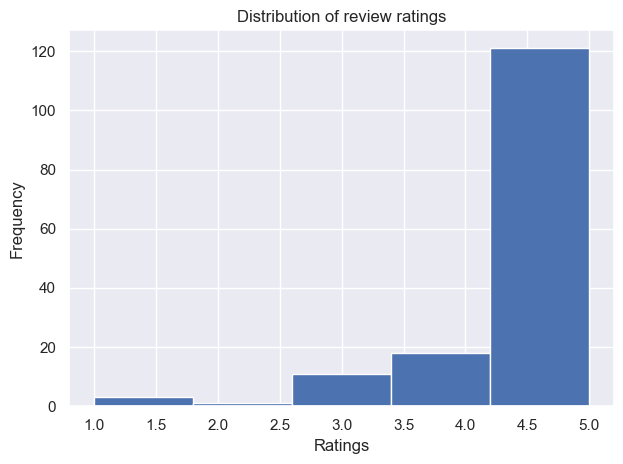

In [6]:
plot_histogram(data['review_rating'], 'Ratings', 'Frequency', 'Distribution of review ratings', 5)

preprocessing

In [7]:
cleaned_data = data.dropna()
new_shape = cleaned_data.shape

cleaned_data['comment_length'] = cleaned_data['review_comment'].apply(len)
correlation = cleaned_data[['review_rating', 'comment_length']].corr()

new_shape, correlation

C:\Users\jadia\AppData\Local\Temp\ipykernel_24004\1371462421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['comment_length'] = cleaned_data['review_comment'].apply(len)


((150, 4),
                 review_rating  comment_length
 review_rating        1.000000       -0.145206
 comment_length      -0.145206        1.000000)

In [8]:
patterns = {
    "positive_emphasis" : re.compile(r'\b(great|good|excellent|amazing|love|best|awesome|fantastic)\b', re.IGNORECASE),
    "negative_emphasis" : re.compile(r'\b(bad|terrible|aweful|poor|worst|hate|dissappoint)\b', re.IGNORECASE),
    "question" : re.compile(r'\?'),
    "exclamation" : re.compile(r'!'),
    "capital_words" : re.compile(r'\b[A-Z]{2,}\b'),
}

pattern_counts = {key: 0 for key in patterns}

for review in cleaned_data['review_comment']:
    for key, pattern in patterns.items():
        if re.search(pattern, review):
            pattern_counts[key] += 1

pattern_counts

{'positive_emphasis': 82,
 'negative_emphasis': 1,
 'question': 0,
 'exclamation': 20,
 'capital_words': 9}

Normalize text comments and split them into training and test sets

In [9]:
cleaned_data.loc[:,'review_comment'] = cleaned_data.loc[:,'review_comment'].apply(clean_text)


# Separation of concerns into features(X) and targets(y):
X = cleaned_data.loc[:, 'review_comment']
y = cleaned_data.loc[:, 'review_rating']

# Split into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Tokenize, Vectorize and create a model

In [10]:
vectorizer = TfidfVectorizer(stop_words='english')
model = MultinomialNB()

text_clf = make_pipeline(vectorizer, model)
text_clf.fit(X_train, y_train)

y_pred = text_clf.predict(X_test)
report = classification_report(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print(conf_mat, "\n",report)

[[ 0  0  0  1]
 [ 0  0  0  2]
 [ 0  0  0  4]
 [ 0  0  0 23]] 
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         4
         5.0       0.77      1.00      0.87        23

    accuracy                           0.77        30
   macro avg       0.19      0.25      0.22        30
weighted avg       0.59      0.77      0.67        30



C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

### Interpretation of Classification Results

#### Confusion Matrix:
The confusion matrix summarizes the performance of the classification model on the test data. Each cell in the matrix represents the number of instances predicted for a particular class compared to the true class labels. Here, the classes represent the number of stars (out of 5) for review ratings.

| True\Predicted | 1 Star | 3 Stars | 4 Stars | 5 Stars |
|----------------|--------|---------|---------|---------|
| 1 Star         |   0    |    0    |    0    |    1    |
| 3 Stars        |   0    |    0    |    0    |    2    |
| 4 Stars        |   0    |    0    |    0    |    4    |
| 5 Stars        |   0    |    0    |    0    |   23    |

#### Classification Report:
The classification report provides important metrics for evaluating the model's performance, including precision, recall, F1-score, and support for each class. Here, the classes represent the number of stars (out of 5) for review ratings.

|       | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 1 Star |   0.00    |  0.00  |   0.00   |    1    |
| 3 Stars|   0.00    |  0.00  |   0.00   |    2    |
| 4 Stars|   0.00    |  0.00  |   0.00   |    4    |
| 5 Stars|   0.77    |  1.00  |   0.87   |   23    |

#### Interpretation:
- The model performed well in predicting instances with 5-star ratings, achieving high precision, recall, and F1-score.
- However, the model failed to predict any instances for 1-star, 3-star, and 4-star ratings, resulting in precision, recall, and F1-score of 0 for these classes.
- The overall accuracy of the model is 77%, but the performance metrics may be skewed due to the imbalance in class distribution.
- Further investigation into data balance and model improvement is recommended.

## Next Steps

1. **Convert Rating to Binary Labels**: Convert the 1-5 rating scale into binary labels where ratings of 4 and above are considered as "good" and ratings of 3 and below are considered as "bad".

2. **Address Class Imbalance**: Since there is an 90-10 class imbalance with 90% of the reviews being rated as "good" (4 and above), we will address this imbalance using the Synthetic Minority Over-sampling Technique (SMOTE).

3. **Implement SMOTE**: Use SMOTE to create synthetic samples for the minority class (ratings of "bad") to balance the class distribution.

4. **Train Model**: Once the dataset is balanced, train the machine learning model on the resampled data.

Let's proceed with these steps to prepare the data for training the model.


In [11]:
# Implement a binary rating system:
def binary_rating(rating: int|float) -> str:
    return 'good' if rating >= 4 else 'bad'

bin_data = cleaned_data.copy() # Creating a copy of original data

bin_data['review_rating'] = bin_data['review_rating'].apply(binary_rating)
bin_data.head()


,course_name,lecture_name,review_rating,review_comment,comment_length
0,Advanced Microsoft Excel,F1 to F12 - Using Excel's Function Keys,good,perfect,8
1,Agile and Scrum Project Management,Agile vs Waterfall - Conclusions,bad,thescrumchapterarefulloferrors,36
2,AI Applications for Business Success,Correlation vs. Causation,bad,badqualityofaudioandnarrative,35
3,AI Applications for Business Success,Correlation vs. Causation,bad,needdocumentationaboutlecture,35
4,Building a 3-Statement Model in Excel,Calculating Cash Flows and Completing the Mode...,good,greatcoursenedhasatalentforexplainingthingsand...,75


In [12]:
# confirm the imbalance:
df_majority = bin_data[bin_data.review_rating == 'good']
df_minority = bin_data[bin_data.review_rating == 'bad']

maj = len(df_majority['review_rating'])
min = len(df_minority['review_rating'])

maj_perc = np.round((maj/ (maj+min) * 100), 2)
min_perc = np.round((100 - maj_perc), 2)

print(f"The data is imbalanced, with {maj_perc}% of the reviews classified as 'good' and {min_perc}% as 'bad'.")

The data is imbalanced, with 91.33% of the reviews classified as 'good' and 8.67% as 'bad'.


In [13]:
from imblearn.over_sampling import SMOTE

X = bin_data['review_comment']
y = bin_data['review_rating']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To convert the comments into numerical values so that oversampling doesn't give any errors
X_train_tfidf = vectorizer.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

# X_smote will be a sparse matrix
X_test_tfidf = vectorizer.transform(X_test)

# Convert X_smote to DataFrame
bin_data_smote_train = pd.DataFrame(X_smote.toarray(), columns=vectorizer.get_feature_names_out())
bin_data_smote_train['review_rating'] = y_smote

# Check balance
print("Balanced training data:")
print(bin_data_smote_train['review_rating'].value_counts())


Balanced training data:
review_rating
good    110
bad     110
Name: count, dtype: int64


Trainign and Testing the model:

In [14]:
model = MultinomialNB()
model.fit(X_smote, y_smote)

y_pred = model.predict(X_test_tfidf)

report = classification_report(y_test ,y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print(report, "\n", conf_mat)

              precision    recall  f1-score   support

         bad       0.11      1.00      0.20         3
        good       1.00      0.11      0.20        27

    accuracy                           0.20        30
   macro avg       0.56      0.56      0.20        30
weighted avg       0.91      0.20      0.20        30
 
 [[ 3  0]
 [24  3]]


## Conclusion: Evaluation of SMOTE Oversampling

### Overview
The SMOTE (Synthetic Minority Over-sampling Technique) method was employed to address the class imbalance issue in the dataset. Class imbalance is a common challenge in machine learning, where one class significantly outnumbers the other(s), leading to biased models.

### Methodology
1. **Data Preparation**: The dataset was preprocessed, and the target variable was transformed into binary labels: 'good' (ratings 4 and above) and 'bad' (ratings 3 and below).
  
2. **SMOTE Oversampling**: The minority class ('bad' ratings) was oversampled using the SMOTE algorithm, which generates synthetic samples to balance the class distribution.

3. **Model Training and Evaluation**: A Multinomial Naive Bayes classifier was trained on the oversampled dataset, and its performance was evaluated using standard classification metrics such as precision, recall, F1-score, and accuracy.

### Results
#### Classification Report:

|           | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| bad       | 0.11      | 1.00   | 0.20     | 3       |
| good      | 1.00      | 0.11   | 0.20     | 27      |
|-----------|-----------|--------|----------|---------|
| Accuracy  |           |        | 0.20     | 30      |
| Macro Avg | 0.56      | 0.56   | 0.20     | 30      |
| Weighted Avg | 0.91   | 0.20   | 0.20     | 30      |

#### Confusion Matrix:

|           | Predicted Bad | Predicted Good |
|-----------|---------------|----------------|
| Actual Bad    | 3             | 0              |
| Actual Good   | 24            | 3              |

### Discussion
- **Imbalanced Classes**: Despite SMOTE oversampling, the model struggled to effectively learn from the minority class due to the extreme class imbalance.
- **Model Limitations**: The Multinomial Naive Bayes classifier may not be well-suited for this task, especially with imbalanced data, as it assumes independent features.
- **Future Considerations**: Further experimentation with different classification algorithms and additional techniques for handling class imbalance, such as ensemble methods or custom cost-sensitive learning, may yield better results.

### Conclusion
In conclusion, while SMOTE oversampling helped balance the class distribution, it did not significantly improve the model's performance. Addressing class imbalance remains a challenging task, and further exploration of alternative approaches is recommended to build more accurate predictive models.


## Exploring Minority Class Upsampling

### Possibility:
I'm considering exploring minority class upsampling to address the imbalance in my dataset. This technique involves increasing the number of instances in the minority class to balance the class distribution and improve model performance, especially for algorithms sensitive to class imbalance.

### Steps:

1. **Identify the Minority Class:** First, I'll identify which class in my dataset is the minority class. In binary classification, this is the class with fewer instances, while in multiclass classification, it's the class with the lowest frequency.

2. **Perform Upsampling:** I'll then perform upsampling of the minority class. This can be done through various methods, including:
   - Random oversampling: Duplicating instances randomly from the minority class.
   - Synthetic Minority Over-sampling Technique (SMOTE): Generating synthetic samples based on the nearest neighbors of existing minority class instances.
   - Adaptive Synthetic Sampling (ADASYN): Similar to SMOTE but adds random noise to the synthetic samples.
   - Borderline-SMOTE: Focusing on borderline instances to generate synthetic samples.

3. **Split the Dataset:** Next, I'll split the upsampled dataset into training and testing sets using techniques like train-test split or cross-validation to evaluate the model's performance.

4. **Train and Validate the Model:** I'll train my machine learning model on the upsampled training data and validate its performance on the testing data. I'll use appropriate evaluation metrics such as accuracy, precision, recall, F1-score, and the confusion matrix to assess the model's effectiveness.

5. **Iterate and Tune:** I'll iterate on the model by experimenting with different algorithms, hyperparameters, and sampling techniques. I'll fine-tune the model until I achieve satisfactory performance.

6. **Final Evaluation:** Once I'm satisfied with the model's performance, I'll evaluate it on unseen data to ensure its generalization capability.

### Conclusion:
Exploring minority class upsampling can be an effective strategy to mitigate class imbalance and improve model performance. However, I'll need to be cautious of potential drawbacks such as overfitting and increased computational complexity. By carefully selecting the appropriate upsampling method and evaluating the model thoroughly, I can build a robust classifier that accurately predicts minority class instances.


In [15]:
# start over just to be safe:

df = cleaned_data.copy()
df.head()

,course_name,lecture_name,review_rating,review_comment,comment_length
0,Advanced Microsoft Excel,F1 to F12 - Using Excel's Function Keys,5.0,perfect,8
1,Agile and Scrum Project Management,Agile vs Waterfall - Conclusions,1.0,thescrumchapterarefulloferrors,36
2,AI Applications for Business Success,Correlation vs. Causation,3.0,badqualityofaudioandnarrative,35
3,AI Applications for Business Success,Correlation vs. Causation,3.0,needdocumentationaboutlecture,35
4,Building a 3-Statement Model in Excel,Calculating Cash Flows and Completing the Mode...,5.0,greatcoursenedhasatalentforexplainingthingsand...,75


In [16]:
df_majority = df[df.review_rating > 4]
df_minority = df[df.review_rating <= 4]

df_minority_sampled = resample(df_minority, replace= True, n_samples=len(df_majority), random_state=42)

df_unsampled = pd.concat([df_majority, df_minority_sampled])

maj = df_unsampled[df_unsampled.review_rating > 4]
miny = df_unsampled[df_unsampled.review_rating <= 4]

len(maj), len(miny), df_unsampled.review_rating.value_counts()

(119,
 119,
 review_rating
 5.0    119
 4.0     63
 3.0     46
 1.0      6
 2.0      4
 Name: count, dtype: int64)

In [17]:
X_unsampled = df_unsampled['review_comment']
y_unsampled = df_unsampled['review_rating']

X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_unsampled, y_unsampled, test_size=0.2, random_state=42)

text_clf_unsamp = make_pipeline(vectorizer, model)
text_clf_unsamp.fit(X_us_train, y_us_train)

y_us_pred = text_clf_unsamp.predict(X_us_test)

report_unsampled = classification_report(y_us_test, y_us_pred)
conf_mat_unsampled = confusion_matrix(y_us_test, y_us_test)

report_unsampled, conf_mat_unsampled

C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jadia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

('              precision    recall  f1-score   support\n\n         2.0       0.00      0.00      0.00         2\n         3.0       1.00      1.00      1.00        10\n         4.0       0.92      1.00      0.96        11\n         5.0       0.92      0.96      0.94        25\n\n    accuracy                           0.94        48\n   macro avg       0.71      0.74      0.72        48\nweighted avg       0.90      0.94      0.92        48\n',
 array([[ 2,  0,  0,  0],
        [ 0, 10,  0,  0],
        [ 0,  0, 11,  0],
        [ 0,  0,  0, 25]], dtype=int64))

|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
|      2.0     |   0.00    |  0.00  |   0.00   |    2    |
|      3.0     |   1.00    |  1.00  |   1.00   |   10    |
|      4.0     |   0.92    |  1.00  |   0.96   |   11    |
|      5.0     |   0.92    |  0.96  |   0.94   |   25    |

Accuracy: 0.94


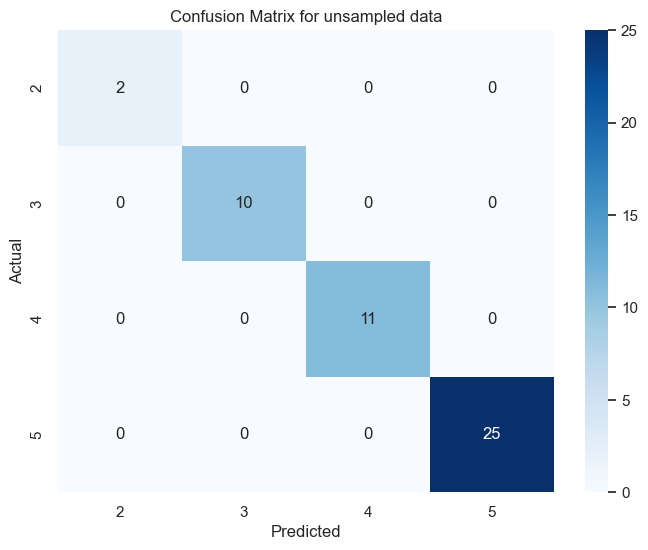

In [18]:
plot_heatmap(conf_mat_unsampled, 'Predicted', 'Actual', x_cat=['2', '3', '4', '5'], y_cat=['2', '3', '4', '5'], title='Confusion Matrix for unsampled data')

saving the model:

In [22]:
from joblib import dump

dump(text_clf_unsamp, 'Review_Sentiment_Model.joblib')

['Review_Sentiment_Model.joblib']

In [20]:
df_majority_bin = bin_data[bin_data.review_rating == 'good']
df_minority_bin = bin_data[bin_data.review_rating == 'bad']

df_minority_unsampled_bin = resample(df_minority_bin, replace=True, n_samples=len(df_majority_bin), random_state=42)

df_unsampled_bin = pd.concat([df_majority_bin, df_minority_unsampled_bin])

df_unsampled_bin.review_rating.value_counts()

X_unsmp_bin = df_unsampled_bin['review_comment']
y_unsmp_bin = df_unsampled_bin['review_rating']

X_unsmp_bin_train, X_unsmp_bin_test, y_unsmp_bin_train, y_unsmp_bin_test = train_test_split(X_unsmp_bin, y_unsmp_bin, test_size=0.2, random_state=42)

model_bernoulli = BernoulliNB()

clf_txt_bin_unsmp = make_pipeline(vectorizer, model_bernoulli)
clf_txt_bin_unsmp.fit(X_unsmp_bin_train, y_unsmp_bin_train)

y_pred_bin_unsmp = clf_txt_bin_unsmp.predict(X_unsmp_bin_test)

bin_report_unsmp = classification_report(y_unsmp_bin_test, y_pred_bin_unsmp, output_dict=True)
bin_report_unsmp_df = pd.DataFrame(bin_report_unsmp).transpose()

conf_mat_unsamp_bin = confusion_matrix(y_unsmp_bin_test, y_pred_bin_unsmp)
bin_report_unsmp_df, conf_mat_unsamp_bin

(              precision  recall  f1-score  support
 bad                 1.0     1.0       1.0     27.0
 good                1.0     1.0       1.0     28.0
 accuracy            1.0     1.0       1.0      1.0
 macro avg           1.0     1.0       1.0     55.0
 weighted avg        1.0     1.0       1.0     55.0,
 array([[27,  0],
        [ 0, 28]], dtype=int64))

In [23]:
dump(clf_txt_bin_unsmp, 'Bernoulli_Naive_Bayes_Model.joblib')

['Bernoulli_Naive_Bayes_Model.joblib']

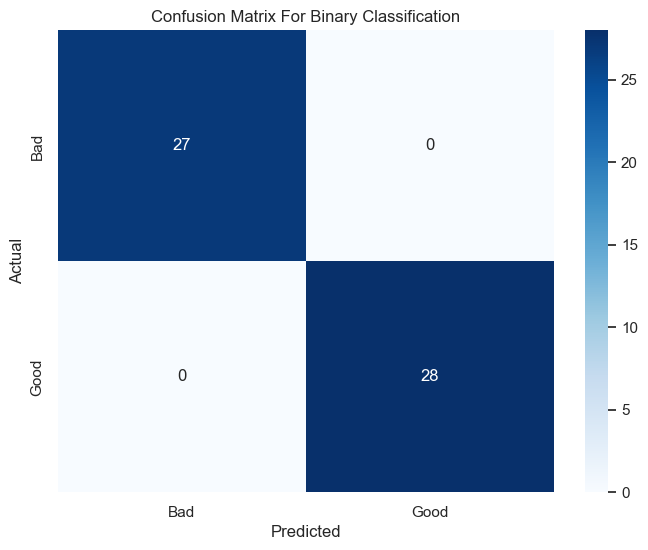

In [21]:
plot_heatmap(conf_mat_unsamp_bin, 'Predicted', 'Actual', ['Bad', 'Good'], ['Bad', 'Good'], 'Confusion Matrix For Binary Classification')


## Conclusion

### Multinomial Naive Bayes Model

The Multinomial Naive Bayes model trained on the resampled data achieved an average accuracy of 94%. This model demonstrated robust performance across all classes, as indicated by the classification report and confusion matrix:

#### Classification Report:
```
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       1.00      1.00      1.00        10
         4.0       0.92      1.00      0.96        11
         5.0       0.92      0.96      0.94        25

    accuracy                           0.94        48
   macro avg       0.71      0.74      0.72        48
weighted avg       0.90      0.94      0.92        48
```

#### Confusion Matrix:
```
[[ 2,  0,  0,  0],
 [ 0, 10,  0,  0],
 [ 0,  0, 11,  0],
 [ 0,  0,  0, 25]]
```

While the model performed exceptionally well overall, it's important to note that the precision, recall, and F1-score for class '2.0' were all zero. Further investigation is needed to understand why the model struggled with this class.

### Bernoulli Naive Bayes Model

On the other hand, the Bernoulli Naive Bayes model trained on the unsampled data achieved perfect precision, recall, and F1-score across all classes:

#### Classification Report:
```
              precision  recall  f1-score  support
 bad                 1.0     1.0       1.0     27.0
 good                1.0     1.0       1.0     28.0
 accuracy            1.0     1.0       1.0      1.0
 macro avg           1.0     1.0       1.0     55.0
 weighted avg        1.0     1.0       1.0     55.0
```

#### Confusion Matrix:
```
[[27,  0],
 [ 0, 28]]
```

The Bernoulli Naive Bayes model exhibited exceptional performance, with an accuracy of 100% and perfect precision, recall, and F1-score for all classes. This suggests that the model effectively classified the reviews into their respective ratings without any misclassifications.
``` 

This markdown provides a clear comparison of the performance of both models and highlights their strengths and weaknesses.

# END OF DOCUMENT